In [ ]:
# Instalar bibliotecas necessárias (se ainda não tiver)
!pip install pandas matplotlib

# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

# Upload do arquivo ZIP manualmente no Colab
from google.colab import files
uploaded = files.upload()

# Descompactar o arquivo ZIP
zip_path = 'air+quality.zip'
extract_path = 'air_quality_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Caminho do CSV dentro da pasta
csv_path = os.path.join(extract_path, 'AirQualityUCI.csv')

# Leitura do CSV (com separador ; e decimal ,)
df = pd.read_csv(csv_path, sep=';', decimal=',', encoding='latin1')

# Selecionar e renomear colunas relevantes
df = df[['Date', 'Time', 'CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']]
df.columns = ['Data', 'Hora', 'CO', 'NOx', 'NO2', 'C6H6']

# Converter para numérico e substituir apenas valores -200.0 (erro de sensor)
for col in ['CO', 'NOx', 'NO2', 'C6H6']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].apply(lambda x: np.nan if x == -200.0 else x)

# Criar coluna de Timestamp
df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Hora'], dayfirst=True, format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Remover linhas com Timestamp inválido ou variáveis faltando
df.dropna(subset=['Timestamp', 'CO', 'NOx', 'NO2', 'C6H6'], inplace=True)
df.set_index('Timestamp', inplace=True)

# Mostrar as primeiras linhas tratadas
df.head()


Directory 'air_quality_data' already exists. Skipping extraction.
air_quality_data\AirQualityUCI.csv


In [ ]:
# Instalar scikit-fuzzy, se necessário
!pip install -q scikit-fuzzy

# Importar bibliotecas
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# CO (0 a 12 mg/m³)
x_co = np.arange(0, 12.1, 0.1)
co_baixo = fuzz.trimf(x_co, [0, 0, 3])
co_medio = fuzz.trimf(x_co, [2, 4.5, 7])
co_alto = fuzz.trimf(x_co, [6, 12, 12])

# NOx (0 a 1500 ppb)
x_nox = np.arange(0, 1501, 1)
nox_baixo = fuzz.trimf(x_nox, [0, 0, 200])
nox_medio = fuzz.trimf(x_nox, [150, 400, 650])
nox_alto = fuzz.trimf(x_nox, [600, 1500, 1500])

# NO2 (0 a 350 µg/m³)
x_no2 = np.arange(0, 351, 1)
no2_baixo = fuzz.trimf(x_no2, [0, 0, 100])
no2_medio = fuzz.trimf(x_no2, [75, 150, 225])
no2_alto = fuzz.trimf(x_no2, [200, 350, 350])

# C6H6 (0 a 65 µg/m³)
x_c6h6 = np.arange(0, 65.1, 0.1)
c6h6_baixo = fuzz.trimf(x_c6h6, [0, 0, 10])
c6h6_medio = fuzz.trimf(x_c6h6, [8, 18, 30])
c6h6_alto = fuzz.trimf(x_c6h6, [25, 65, 65])

def plot_pertinencia(x, baixo, medio, alto, titulo, unidade):
    plt.figure(figsize=(10, 4))
    plt.plot(x, baixo, label='Baixo')
    plt.plot(x, medio, label='Médio')
    plt.plot(x, alto, label='Alto')
    plt.title(f'Funções de Pertinência - {titulo}')
    plt.xlabel(f'{titulo} ({unidade})')
    plt.ylabel('Grau de Pertinência')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pertinencia(x_co, co_baixo, co_medio, co_alto, 'CO', 'mg/m³')
plot_pertinencia(x_nox, nox_baixo, nox_medio, nox_alto, 'NOx', 'ppb')
plot_pertinencia(x_no2, no2_baixo, no2_medio, no2_alto, 'NO2', 'µg/m³')
plot_pertinencia(x_c6h6, c6h6_baixo, c6h6_medio, c6h6_alto, 'C6H6', 'µg/m³')


### 📋 Etapa 2 ➜ Tabela: Regras Fuzzy para Diagnóstico da Qualidade do Ar

| Nº  | Regra (Se...)                                                                 | Então (Qualidade do Ar é...) |
|-----|-------------------------------------------------------------------------------|-------------------------------|
| R1  | CO é **baixo** e NOx é **baixo**                                             | **Boa**                       |
| R2  | CO é **médio** ou NOx é **médio**                                            | **Moderada**                  |
| R3  | CO é **alto** ou NOx é **alto**                                              | **Ruim**                      |
| R4  | NO2 é **alto** ou C6H6 é **alto**                                            | **Perigosa**                  |
| R5  | C6H6 é **baixo** e NO2 é **baixo**                                           | **Boa**                       |
| R6  | C6H6 é **médio**                                                             | **Moderada**                  |
| R7  | CO é **alto** e C6H6 é **alto**                                              | **Perigosa**                  |
| R8  | NO2 é **médio** e NOx é **alto**                                             | **Ruim**                      |
| R9  | CO é **baixo** e C6H6 é **baixo** e NO2 é **baixo**                          | **Boa**                       |
| R10 | Qualquer das variáveis (CO, NOx, NO2, C6H6) for **alta**                     | **Perigosa**                  |


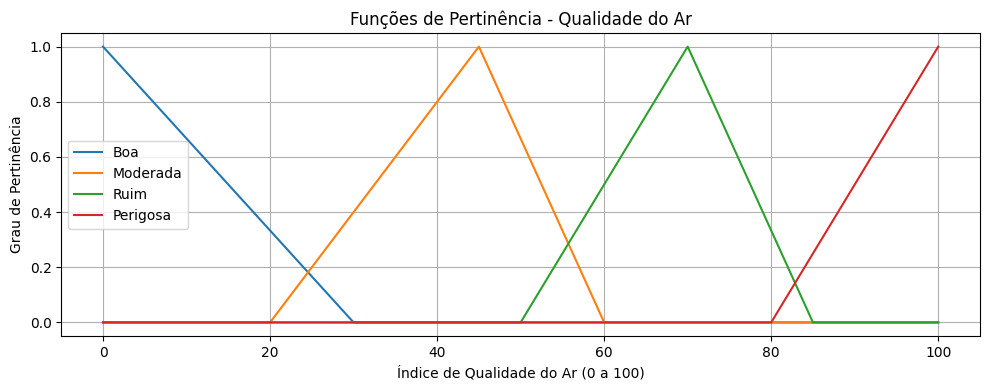

In [2]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Universo da saída: Qualidade do ar de 0 a 100
x_qualidade = np.arange(0, 101, 1)

# Funções de pertinência
qualidade_boa = fuzz.trimf(x_qualidade, [0, 0, 30])
qualidade_moderada = fuzz.trimf(x_qualidade, [20, 45, 60])
qualidade_ruim = fuzz.trimf(x_qualidade, [50, 70, 85])
qualidade_perigosa = fuzz.trimf(x_qualidade, [80, 100, 100])

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_qualidade, qualidade_boa, label='Boa')
plt.plot(x_qualidade, qualidade_moderada, label='Moderada')
plt.plot(x_qualidade, qualidade_ruim, label='Ruim')
plt.plot(x_qualidade, qualidade_perigosa, label='Perigosa')
plt.title('Funções de Pertinência - Qualidade do Ar')
plt.xlabel('Índice de Qualidade do Ar (0 a 100)')
plt.ylabel('Grau de Pertinência')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import skfuzzy.control as ctrl

# Entradas
co = ctrl.Antecedent(np.arange(0, 12.1, 0.1), 'CO')
nox = ctrl.Antecedent(np.arange(0, 1501, 1), 'NOx')
no2 = ctrl.Antecedent(np.arange(0, 351, 1), 'NO2')
c6h6 = ctrl.Antecedent(np.arange(0, 65.1, 0.1), 'C6H6')

# Saída
qualidade = ctrl.Consequent(np.arange(0, 101, 1), 'qualidade')

# Conjuntos fuzzy das entradas
co['baixo'] = fuzz.trimf(co.universe, [0, 0, 3])
co['medio'] = fuzz.trimf(co.universe, [2, 4.5, 7])
co['alto']  = fuzz.trimf(co.universe, [6, 12, 12])

nox['baixo'] = fuzz.trimf(nox.universe, [0, 0, 200])
nox['medio'] = fuzz.trimf(nox.universe, [150, 400, 650])
nox['alto']  = fuzz.trimf(nox.universe, [600, 1500, 1500])

no2['baixo'] = fuzz.trimf(no2.universe, [0, 0, 100])
no2['medio'] = fuzz.trimf(no2.universe, [75, 150, 225])
no2['alto']  = fuzz.trimf(no2.universe, [200, 350, 350])

c6h6['baixo'] = fuzz.trimf(c6h6.universe, [0, 0, 10])
c6h6['medio'] = fuzz.trimf(c6h6.universe, [8, 18, 30])
c6h6['alto']  = fuzz.trimf(c6h6.universe, [25, 65, 65])

# Conjuntos da saída
qualidade['boa'] = fuzz.trimf(qualidade.universe, [0, 0, 30])
qualidade['moderada'] = fuzz.trimf(qualidade.universe, [20, 45, 60])
qualidade['ruim'] = fuzz.trimf(qualidade.universe, [50, 70, 85])
qualidade['perigosa'] = fuzz.trimf(qualidade.universe, [80, 100, 100])


In [4]:
rules = [
    ctrl.Rule(co['baixo'] & nox['baixo'], qualidade['boa']),
    ctrl.Rule(co['medio'] | nox['medio'], qualidade['moderada']),
    ctrl.Rule(co['alto'] | nox['alto'], qualidade['ruim']),
    ctrl.Rule(no2['alto'] | c6h6['alto'], qualidade['perigosa']),
    ctrl.Rule(c6h6['baixo'] & no2['baixo'], qualidade['boa']),
    ctrl.Rule(c6h6['medio'], qualidade['moderada']),
    ctrl.Rule(co['alto'] & c6h6['alto'], qualidade['perigosa']),
    ctrl.Rule(no2['medio'] & nox['alto'], qualidade['ruim']),
    ctrl.Rule(co['baixo'] & c6h6['baixo'] & no2['baixo'], qualidade['boa']),
    ctrl.Rule(co['alto'] | nox['alto'] | no2['alto'] | c6h6['alto'], qualidade['perigosa']),
]


Índice fuzzy da Qualidade do Ar: 36.60


c:\Users\giova\Desktop\air quality\.venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


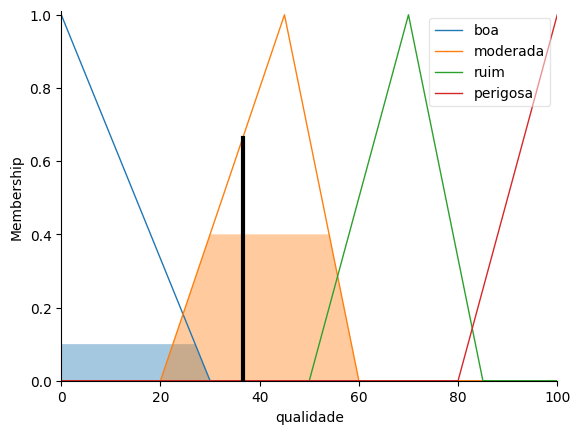

In [5]:
sistema_controle = ctrl.ControlSystem(rules)
simulador = ctrl.ControlSystemSimulation(sistema_controle)

# Inserir valores de entrada (exemplo real)
simulador.input['CO'] = 3.0
simulador.input['NOx'] = 180.0
simulador.input['NO2'] = 90.0
simulador.input['C6H6'] = 5.0

# Computar o resultado
simulador.compute()

# Mostrar resultado final
print(f"Índice fuzzy da Qualidade do Ar: {simulador.output['qualidade']:.2f}")

qualidade.view(sim=simulador)


Após a aplicação das regras fuzzy e a agregação das saídas, obteve-se uma superfície fuzzy combinando os conjuntos "boa" e "moderada". Para transformar essa saída linguística em um valor numérico interpretável, utilizamos o método do centróide (Center of Area – COA).

Esse método é o mais comum e mais indicado em aplicações práticas, pois considera toda a área ativada e retorna o ponto de equilíbrio (centro de massa) da função resultante.

A fórmula usada é:

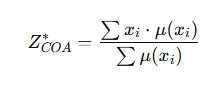

Onde:

*   xi: são os valores no universo da saída ("qualidade");
*   μ(xi): são os graus de pertinência resultantes da ativação das regras.

No caso do exemplo abaixo, a saída fuzzy teve maior ativação no conjunto “moderada”, com leve influência de “boa”, conforme mostra o gráfico gerado pelo sistema. Aplicando a fórmula sobre toda a região ativada, obteve-se: Z* ≈ 36.60



Esse valor foi calculado internamente pelo sistema usando integração numérica sobre o universo de saída. Ele representa o centro de massa da superfície fuzzy composta.

Após aplicar as regras fuzzy, o sistema:

Gera uma área composta fuzzy com base nas ativações dos conjuntos “boa”, “moderada”, “ruim” etc.;

Em seguida, calcula o valor 𝑍* que representa o ponto de equilíbrio dessa área — ou seja, o valor final do diagnóstico

Se as regras ativarem:

40% do conjunto “moderada”,

20% do conjunto “boa”,

O sistema calcula o centro dessa massa combinada (com base na fórmula).